# Most Consistent Hitters In The Last 30 Years.

In [1]:
# Things we'll need.
import pandas as pd
import numpy as np
import sqlite3 as sql
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [2]:
# Defining our connector the the database
conn = sql.connect('database.sqlite')
c = conn.cursor()

# Player Information

In [3]:
PlayerInfo = pd.DataFrame(list(c.execute('''select player_id, name_first, 
                                             name_last, debut, final_game from player''')))
names = list(map(lambda x: x[0], c.description))
PlayerInfo.columns = names
PlayerInfo.head()

,player_id,name_first,name_last,debut,final_game
0,aardsda01,David,Aardsma,2004-04-06,2015-08-23
1,aaronha01,Hank,Aaron,1954-04-13,1976-10-03
2,aaronto01,Tommie,Aaron,1962-04-10,1971-09-26
3,aasedo01,Don,Aase,1977-07-26,1990-10-03
4,abadan01,Andy,Abad,2001-09-10,2006-04-13


# Batting average by season per player

In [4]:
PBY = pd.DataFrame(list(c.execute('''select player_id, year, 
                                     1.*h/(ab-ibb-hbp) as batting_percentage 
                                     from batting group by year, player_id''')))
names = list(map(lambda x: x[0], c.description))
PBY.columns = names
PBY.head()

,player_id,year,batting_percentage
0,abercda01,1871,0.000000
1,addybo01,1871,0.271186
2,allisar01,1871,0.291971
3,allisdo01,1871,0.330827
4,ansonca01,1871,0.325000


# Average batting average per season

In [5]:
Career = PBY.groupby('player_id')['batting_percentage'].agg([np.mean, np.std]).reset_index()
Career.columns = [['player_id', 'career_batting_percentage', 'career_batting_std']]
Career.head()

,player_id,career_batting_percentage,career_batting_std
0,aardsda01,0.000000,0.000000
1,aaronha01,0.309195,0.033387
2,aaronto01,0.221619,0.023463
3,aasedo01,0.000000,NaN
4,abadan01,0.039216,0.067924


# Numbers of years Actively playing

In [6]:
YearsActive = PBY.groupby('player_id')['year'].count().reset_index()
YearsActive.columns = ['player_id', 'years_active']
YearsActive = YearsActive[YearsActive['years_active'] >= 4]

## The average baseball player plays for 4.5 years so lets focus on those who played more than 4 years.

# Let's take a quick look at who had the longest career.

In [7]:
YearsActive.sort_values('years_active', ascending=False).head(10).merge(PlayerInfo, how='left', on='player_id')

,player_id,years_active,name_first,name_last,debut,final_game
0,ryanno01,27,Nolan,Ryan,1966-09-11,1993-09-22
1,ansonca01,27,Cap,Anson,1871-05-06,1897-10-03
2,johnto01,26,Tommy,John,1963-09-06,1989-05-25
3,mcguide01,26,Deacon,McGuire,1884-06-21,1912-05-18
4,wallabo01,25,Bobby,Wallace,1894-09-15,1918-09-02
5,henderi01,25,Rickey,Henderson,1979-06-24,2003-09-19
6,houghch01,25,Charlie,Hough,1970-08-12,1994-07-26
7,kaatji01,25,Jim,Kaat,1959-08-02,1983-07-01
8,collied01,25,Eddie,Collins,1906-09-17,1930-08-05
9,moyerja01,25,Jamie,Moyer,1986-06-16,2012-05-27


# Number of Seasons with a batting average of .3 or more

In [8]:
GreatYears = PBY[PBY['batting_percentage'] >= .3].groupby('player_id')['batting_percentage'].count().reset_index()
GreatYears.columns = ['player_id', 'great_years_amount']

In [9]:
GreatYears.sort_values('great_years_amount', ascending=False).head(3).merge(PlayerInfo, how='left', on='player_id')

,player_id,great_years_amount,name_first,name_last,debut,final_game
0,ansonca01,24,Cap,Anson,1871-05-06,1897-10-03
1,cobbty01,23,Ty,Cobb,1905-08-30,1928-09-11
2,collied01,20,Eddie,Collins,1906-09-17,1930-08-05


# These are the players with more than 20 good seasons.

## Joining previous tables

In [10]:
Stats = GreatYears.merge(YearsActive, how='left', on='player_id')
Stats['percent_of_greatness'] = Stats['great_years_amount']/Stats['years_active']

In [11]:
Stats = Stats.merge(Career, how='left', on='player_id')

In [12]:
data = Stats.merge(PlayerInfo, how='left', on='player_id')

In [14]:
data = data[['name_first', 'name_last','debut', 'percent_of_greatness',
             'final_game','great_years_amount', 'years_active',
             'career_batting_percentage', 'career_batting_std']]

# What are the top ten players with the most consistently great batting average?

In [15]:
data = data[data['debut'] >= '1984-01-01'].sort_values('percent_of_greatness', ascending=False)

In [25]:
data[:15]

,name_first,name_last,debut,percent_of_greatness,final_game,great_years_amount,years_active,career_batting_percentage,career_batting_std
3007,John,Kruk,1986-04-07,0.900000,1995-07-30,9,10.0,0.308694,0.023870
5656,Joey,Votto,2007-09-04,0.888889,2015-10-04,8,9.0,0.319346,0.026748
2127,Vladimir,Guerrero,1996-09-19,0.875000,2011-09-28,14,16.0,0.322487,0.042367
4423,Kirby,Puckett,1984-05-08,0.833333,1995-09-28,10,12.0,0.324110,0.021004
2072,Mike,Greenwell,1985-09-05,0.833333,1996-09-28,10,12.0,0.307466,0.028342
4099,Magglio,Ordonez,1997-08-29,0.800000,2011-09-27,12,15.0,0.310031,0.023614
4477,Manny,Ramirez,1993-09-02,0.789474,2011-04-06,15,19.0,0.306233,0.078929
488,Barry,Bonds,1986-05-30,0.772727,2007-09-26,17,22.0,0.331599,0.070262
765,Miguel,Cabrera,2003-06-20,0.769231,2015-10-03,10,13.0,0.332084,0.028398
3473,Joe,Mauer,2004-04-05,0.750000,2015-10-03,9,12.0,0.319787,0.030910


In [23]:
np.nanpercentile(np.array(data['percent_of_greatness']), 99)

0.72636363636363721

# These players constitute the top .7% of the league for the last 30 years.

In [27]:
np.nanpercentile(np.array(data['percent_of_greatness']), 99.9)

0.88184722222222445

# The top two players constitute the top .1% of the league in the last 30 years!

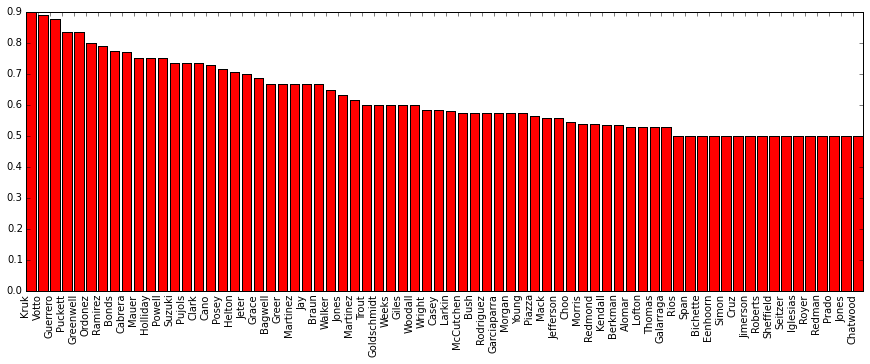

In [29]:
rcParams['figure.figsize'] = 15, 5
x = np.array(list(range(70)))
plt.xticks(x, np.array(data['name_last'][:70]), rotation='vertical')
#plt.plot(x, y)
plt.bar(x, np.array(data['percent_of_greatness'][:70]), color = 'red' )
plt.show()